<a href="https://colab.research.google.com/github/kihtrak-tns/Build-Self-Driving-car-using-NVIDIA-Jetson-Nano/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/kihtrak-tns/Tracks

Cloning into 'Tracks'...
remote: Enumerating objects: 25280, done.
remote: Total 25280 (delta 0), reused 0 (delta 0), pack-reused 25280
Receiving objects: 100% (25280/25280), 324.19 MiB | 41.92 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25277/25277), done.


In [0]:
# !ls Tracks

In [0]:
# !pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [0]:
# The OS module in Python provides a way of using operating system dependent functionality. 
## The functions that the OS module provides allows you to interface with the underlying operating system 
##that Python is running on – be that Windows, Mac or Linux. 

datadir = "Tracks/Second_drive"
columns = ['center', 'left', 'right', 'steering','throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns) 

# To align the complete path with the column header
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\center_2020_02_04_21_14_45_677.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\left_2020_02_04_21_14_45_677.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\right_2020_02_04_21_14_45_677.jpg,0.0,0.0,0.0,0.000079
1,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\center_2020_02_04_21_14_45_778.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\left_2020_02_04_21_14_45_778.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\right_2020_02_04_21_14_45_778.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\center_2020_02_04_21_14_45_883.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\left_2020_02_04_21_14_45_883.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\right_2020_02_04_21_14_45_883.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\center_2020_02_04_21_14_45_988.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\left_2020_02_04_21_14_45_988.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\right_2020_02_04_21_14_45_988.jpg,0.0,0.0,0.0,0.000081
4,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\center_2020_02_04_21_14_46_089.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\left_2020_02_04_21_14_46_089.jpg,C:\Users\Karthik Shanmugam\The_Complete_Self_Driving_Car_Tutorial_from_Udemy\Data\Second_drive\IMG\right_2020_02_04_21_14_46_089.jpg,0.0,0.0,0.0,0.000084


In [0]:
# The idea is to extract just the tail information in the path

def path_leaf(path) :
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_02_04_21_14_45_677.jpg,left_2020_02_04_21_14_45_677.jpg,right_2020_02_04_21_14_45_677.jpg,0.0,0.0,0.0,0.000079
1,center_2020_02_04_21_14_45_778.jpg,left_2020_02_04_21_14_45_778.jpg,right_2020_02_04_21_14_45_778.jpg,0.0,0.0,0.0,0.000081
2,center_2020_02_04_21_14_45_883.jpg,left_2020_02_04_21_14_45_883.jpg,right_2020_02_04_21_14_45_883.jpg,0.0,0.0,0.0,0.000079
3,center_2020_02_04_21_14_45_988.jpg,left_2020_02_04_21_14_45_988.jpg,right_2020_02_04_21_14_45_988.jpg,0.0,0.0,0.0,0.000081
4,center_2020_02_04_21_14_46_089.jpg,left_2020_02_04_21_14_46_089.jpg,right_2020_02_04_21_14_46_089.jpg,0.0,0.0,0.0,0.000084


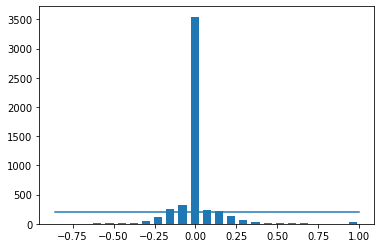

In [0]:
# To print a histogram from our steering data in order to visualize it

num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
#print(bins)

## The model may get biased just because most of the values are centred around 0 because we tried to maintain the car in the center of the track. Hence we need to preprocess the data accordingly

total data 5081
removed 3580
remaining 1501


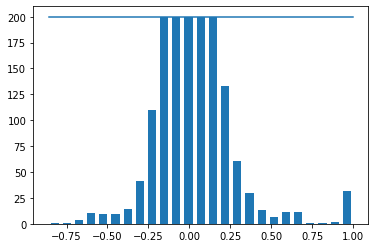

In [0]:
print('total data', len(data))

# samples we want to remove
remove_list = []

for j in range(num_bins) :
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      # the index will point to steering angle i; 
      list_.append(i)
    # a wide range of values might exist between the left and right driving, hence we cannot chop off the 
    # values based on the threshold; rather we shuffle to minimize the loss of information
  list_ = shuffle(list_)

    # isolate samples beyond the threshold
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))

# Drop the data that is pointed by indices stored in the remove_list (ones above the threshold)
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# Distribution of steering angle that are more uniform. We have significant left and right steering data that eliminates the heavy bias of centred driving data.
### When the data is used for autonomous mode, if the car couldn't retrace itself to the middle, then we would have to add more recovery laps to balance out the data. "Recovery laps" can be made clear after we test our model, where the car is driven to either extremes without hitting the sides and steering all the way to the middle rather than "maintaining" the car in the middle of the lane. 

In [0]:
def load_img_steering(datadir, df) :
  image_path = []
  steering = []
  for i in range(len(data)) :
    # .iloc perfroms a selection on a row of data based on specified index 
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # to append the main path of the images; .strip() removes any spaces in the path
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float (indexed_data[3]))
  # convert the lists into array
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  # We need to split the dataset into training and validation datasets


In [0]:
# Use train_test_split to split the dataset into training, validation and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training samples: {} \n Valid Samples: {}' .format(len(X_train), len(X_valid)))

Training samples: 1200 
 Valid Samples: 301


Text(0.5, 1.0, 'Validation set')

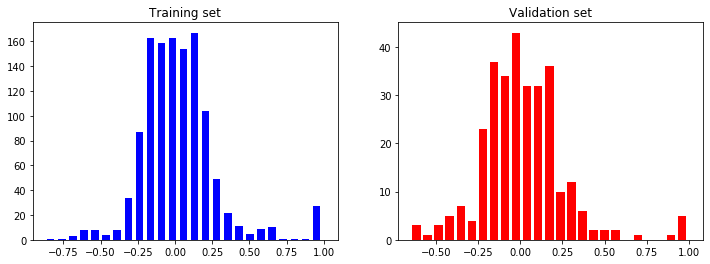

In [0]:
# plt.subplots(num_rows, num_of_plots in row) returns the values to fig and axes with axes having the respective
## histograms

fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

## We apply Image Augmentation techniques to provide the model with enhanced datasets.

In [0]:
def zoom(image):
  #.affine() preserves straight lanes and planes in an image (1, 1.3) -> 0 to 30%
  zoom = iaa.Affine(scale = (1, 1.3))
  # to apply the zoom paramters to our image
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed image')

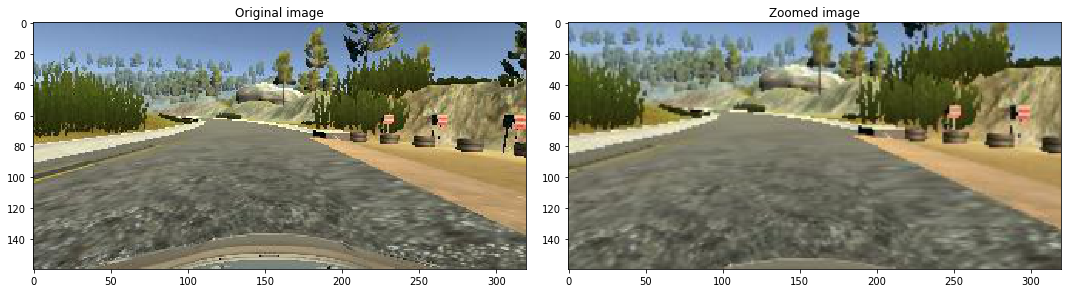

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned image')

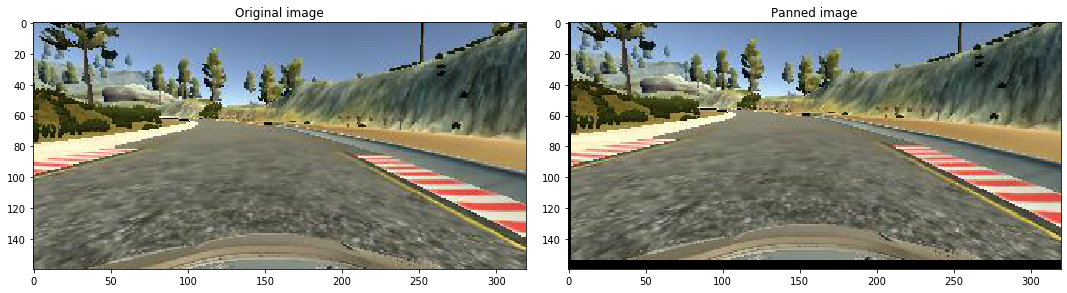

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
def image_random_brightness(image):
  # .multiply() multiplies all the pixel intensities in the image and anything with a value less than 1 
  ## makes them appear darker. Darker images score better compared to brighter ones
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1, 'Brightness altered image')

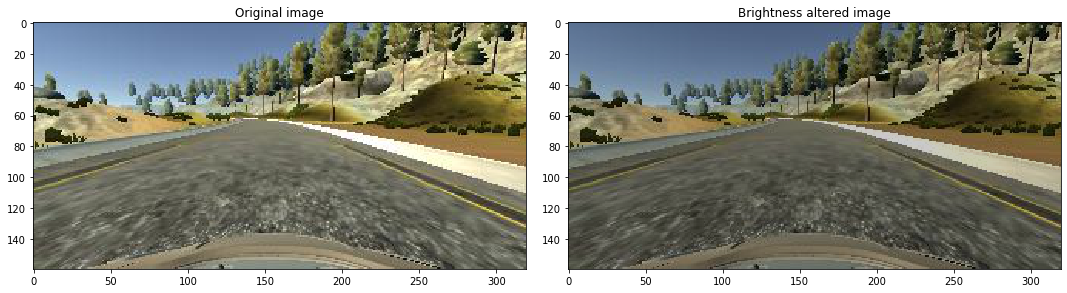

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = image_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

In [0]:
# We flip to balance our datasets
def img_random_flip(image, steering_angle):
  # 0 -> horizontal flip; 1 -> vertical flip; 1- -> combination of both
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1, 'Flipped imageSteering Angle:-0.0')

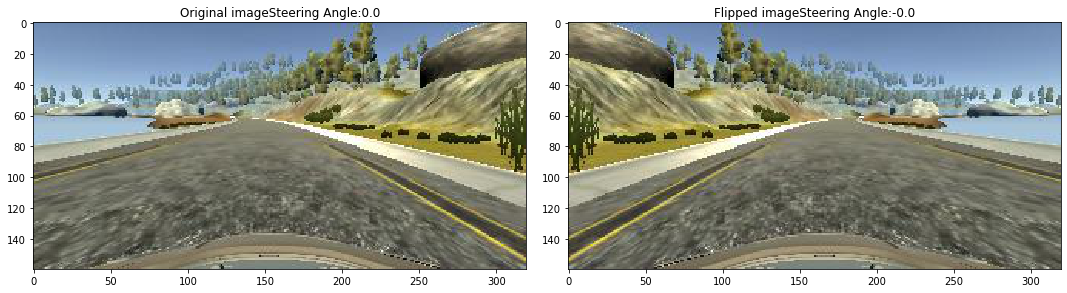

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image' + 'Steering Angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image' + 'Steering Angle:' + str(flipped_steering_angle))

# Applying all the augmentations techniques on every image generated may not help with generalization. Combining them in random, gives more variety and hence helps our model to handle new images

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
    # We try to apply each of the augmentation 50% of the time ( prob ~ 0.5) to keep it diverse
  if np.random.rand() < 0.5 :
    image = pan(image)
  if np.random.rand() < 0.5 :
    image = zoom(image)
  if np.random.rand() < 0.5 :
    image = image_random_brightness(image)
  if np.random.rand() < 0.5 :
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

# We need to preprocess the image in order to get a better model

In [0]:
def img_preprocess(img) :
  # Since we are dealing with image paths, we need a func to read the image from the path
  # img = mpimg.imread(img)

  # The top and bottom portions (bg & hood of the car) of the images aren't necessary for our model hence 
  ## we are only interested in dealing with the 'height' parameter of the image. 
  img = img[60:135, :, :]

  # We're using the NVIDIA model to process our image which recommends YUV format
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  # The Gaussian Blur using Gaussian kernel convolation to smoothen out our image
  img = cv2.GaussianBlur(img, (3, 3), 0)

  # Smaller image results in using less processing power and better model; 
  ## 200 by 66 is chosen because we've planned to use the NVIDIA model arch
  img = cv2.resize(img, (200, 66))

  # Normalize our image
  img = img/255
  return img

Text(0.5, 1, 'Preprocessed_image')

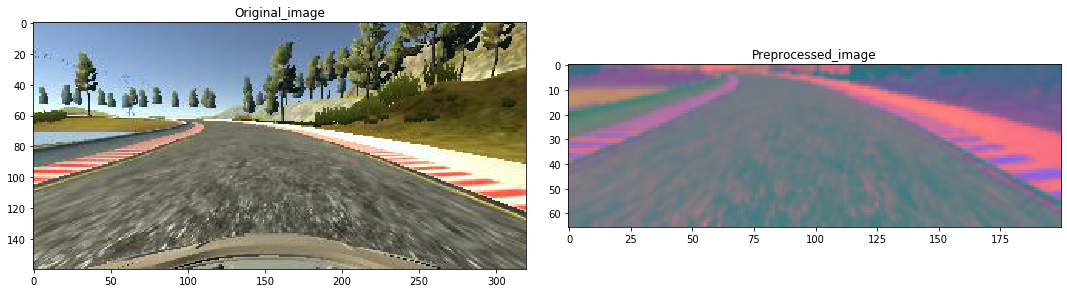

In [0]:
# We choose an arbitary image from our image directory
image = image_paths[100]

# original_image is the raw image and the other is the processed image for our model
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed_image')

# For large datasets, its better to have the augmentation (fit and predict runs) done in batches rather than make the run through the whole dataset.
## The coroutines with the 'yield' statement, when called the caller uses the old values and it is not reinitialized.

In [0]:
# istraining -> bool value = 'true' when the data fed into the generator is training data; 
## 'false' for validation data, since we want our valn data to be raw as the one in the simulation
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []

# Prepare our batch of augmented images
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      # check for training vs validation images
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      # 'yield' puts the batch_generator on hold; local values are maintained and while reinitiates when revisited
    yield (np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1, 'Validation Image')

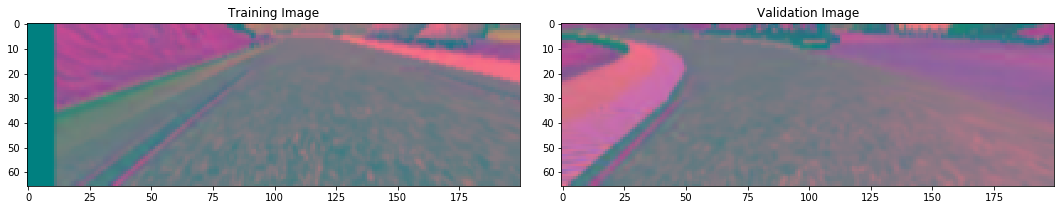

In [0]:
# next() -> calls the iterator item and retreives the next item for it
# We generate one image at a time

x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
# Since we only need training dataset, hence '0'
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# We don't need this in the later stages of the simulation process since we use the generator model on the fly
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# print(X_train.shape)

# We use the 'elu' activation function for our model because 'relu' function is 0 for x less than 0 which makes the backpropogation network not to update the weights (dying relu) and the model fails to learn in those regions. 
# Hence, 'elu' provides values for the model to update its weights even in the negative regions.

In [0]:
# The function defines the NVIDIA model exactly the same way it has been shown in their
## journal -> 'End to End Learning for Self-Driving Cars'

def nvidia_model() :
  model = Sequential()
  # subsample is used to define the stride length of our kernel
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation = 'elu'))
  # since the dimensions of the layers have become quite small to handle, we keep the default
  ## stride length, which is 1
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  # The input to the Fully connected layers is of dimension 1 x 18 x 64 and will output the steering angle 
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  # We keep relatively low learning rate and use the Mean Squared Error function for our model
  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer) 
  return model

In [0]:
model = nvidia_model()
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # This is added back by Interactive

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
# For huge dataset to  be augmented on the fly, we use fit_generator()
# steps_per_epoch -> the number of batch iterations before a training epoch is considered finished
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data= batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose= 1, 
                              shuffle = 1)
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size = 100, verbose =1, shuffle =1)




Epoch 1/10





300/300 [==============================] - 197s 658ms/step - loss: 0.0986 - val_loss: 0.0496
Epoch 2/10
300/300 [==============================] - 181s 603ms/step - loss: 0.0625 - val_loss: 0.0459
Epoch 3/10
300/300 [==============================] - 182s 608ms/step - loss: 0.0611 - val_loss: 0.0458
Epoch 4/10
300/300 [==============================] - 181s 605ms/step - loss: 0.0591 - val_loss: 0.0413
Epoch 5/10
300/300 [==============================] - 183s 610ms/step - loss: 0.0570 - val_loss: 0.0388
Epoch 6/10
300/300 [==============================] - 184s 614ms/step - loss: 0.0581 - val_loss: 0.0383
Epoch 7/10
300/300 [==============================] - 183s 609ms/step - loss: 0.0574 - val_loss: 0.0346
Epoch 8/10
300/300 [==============================] - 183s 611ms/step - loss: 0.0565 - val_loss: 0.0360
Epoch 9/10
300/300 [==============================] - 183s 609ms/step - loss: 0.0557 - val_loss: 0.0383
Epoch 10/10
300/300 [==============================] - 1

Text(0.5, 0, 'Epoch')

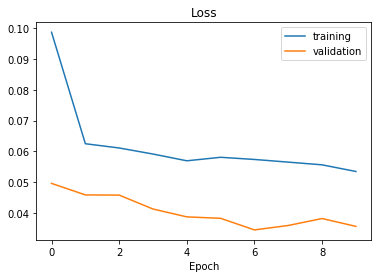

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
#model.save('model.h5')

In [0]:
#from google.colab import files
#files.download('model.h5')